### Konfiguracja

In [61]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from queue import Queue
from matplotlib.widgets import Button
import json as js



# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

%matplotlib notebook

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))


# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax

    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling=True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling=True)

    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))

    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()

    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []

    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling=False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling=False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling=False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (
                        np.mean([self.ax.get_xlim(), self.ax.get_ylim()]) * TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling=False)

    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling=True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [62]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points = points
        self.lines = lines


# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs

    def add_points(self, points):
        self.points = self.points + points


# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs

    def add(self, line):
        self.lines.append(line)

    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)


# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes=[Scene()], points=[], lines=[], json=None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]],
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]])
                           for scene in js.loads(json)]

    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]

    def add_scene(self, scene):
        self.scenes.append(scene)

    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points],
                          "lines": [linesCol.lines for linesCol in scene.lines]}
                         for scene in self.scenes])

        # Metoda ta zwraca punkty dodane w trakcie rysowania.

    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None

    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines + self.callback.added_rects)
        else:
            return None

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on=False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Funkcje pomocnicze

In [63]:
from copy import copy, deepcopy
from random import shuffle
# funkcja orienta zwraca wyznacznik macierzy postaci
#  | ax, ay, 1 |
#  | bx, by, 1 |
#  | cx, cy, 1 |
# wyznacznik ten definiuje po jakiej stronie (lewo / prawo)
# znajduje się punkt c względem wektora -ab->
def orient(a, b, c):
    return a[0] * b[1] + a[1] * c[0] + b[0] * c[1] - b[1] * c[0] - a[1] * b[0] - a[0] * c[1]

# maksymalna odległość między punktami, aby dwa punkty zostały uznane za jeden
EPS = 1e-9

## Struktury reprezentujące punkt, odcinek oraz ścianę (trapez/trójkąt)

In [64]:
class Point:
    def __init__(self, x, y, seg = None):
        self.x = x
        self.y = y
        self.segment = seg

    def __repr__(self):  #do reprezentacji
        return f'{round(self.x, 4)} {round(self.y, 4)}'

    def __str__(self):  #zaokrąglam żeby było bardziej czytelne
        return f'{round(self.x, 4)} {round(self.y, 4)}'

    def set_segment(self, segment):
        self.segment = segment

    def __eq__(self, other):
        return ((self.x - other.x)**2 + (self.y - other.y)**2)**(1/2) < EPS

    def __hash__(self):
        return hash((self.x, self.y))

class Segment:
    def __init__(self, p, q):
        self.p = p
        self.q = q
        if self.p.x > self.q.x:
            self.p, self.q = self.q, self.p
        # parametry reprezentujące prostą, do której należy odcinek
        # prosta ma równanie postaci y = ax + b
        if p.x != q.x:
            self.a = (q.y - p.y) / (q.x - p.x)  # odcinki nie moga byc pionowe - nie ma problemu z dzieleniem przez 0
            self.b = self.p.y - (self.p.x * self.a)

        self.p.set_segment(self)
        self.q.set_segment(self)

    def __eq__(self, other):
        return (self.p == other.p and self.q == other.q) or (self.p == other.q and self.q == other.p)

    def __hash__(self):
        return hash((self.p.x, self.p.y, self.q.x, self.q.y))

    def __repr__(self):  #printuje punkty
        return f'{self.p} {self.q}'

    def __str__(self):
        return f'{self.p} {self.q}'

    # funkcja zwraca polozenie punktu wzgledem prostej
    # jesli punkt znajduje sie nad prosta zwraca liczbe dodatnia
    # wpp liczbe ujemna
    # jesli punkt lezy poza zakresem [p.x, q.x] - 0
    def point_position(self, point):
        if point.x < self.p.x or point.x > self.q.x:
            return 0
        return orient(self.p, self.q, point)

    # zwraca y = a * x + b jesli x miesci sie na odcinku
    # wpp zwraca None
    def y(self, x):
        return self.a * x + self.b

class Trapezoid:  #klasa reprezentująca trapez (Nasza delta)
    def __init__(self):
        self.bottom = None
        self.top = None
        self.leftp = None
        self.rightp = None

        #Wskazniki na sąsiądów trapezu
        self.upper_right = None
        self.lower_right = None
        self.upper_left = None
        self.lower_left = None

        #Wskaznik do node w grafie
        self.node = None

    def __repr__(self):
        return f"{self.top}\n{self.bottom}"

    def __str__(self):
        return f"{self.top}\n{self.bottom}"

class NodeArea:  #Klasa reprezentuje delte w grafie (przestrzeń) ewentualnie do poprawy
    def __init__(self, delta):
        self.delta = delta
        self.parents = [] #Przechowuje informacje o wszystkich Nodach którą są do niego podpiętę

class NodeVertex:  #Klasa reprezentuje wierzchołek w grafie (przestrzeń) ewentualnie do poprawy
    def __init__(self, left_side, right_side, vertex):
        self.left_side = left_side  #Pole przechowuje co się znajduje po lewej stronie wierzchołka
        self.right_side = right_side  #analogicznie
        self.vertex = vertex
        if isinstance(left_side, NodeArea): #zapisuje że area ma parenta
            left_side.parents.append(self)

        if isinstance(right_side, NodeArea): #analogicznie
            right_side.parents.append(self)


# z wykładu NodeX
class NodeSegment:  #Klasa reprezentuje odcinek w grafie (przestrzeń) ewentualnie do poprawy
    def __init__(self, upper_side, lower_side, segment):
        self.upper_side = upper_side  #Pole przechowuje co się znajduję nad odcinkiem
        self.lower_side = lower_side  #analogicznie
        self.segment = segment
        if isinstance(upper_side, NodeArea): #zapisuje że area ma parenta
            upper_side.parents.append(self)

        if isinstance(lower_side, NodeArea): #analogicznie
            lower_side.parents.append(self)


class Graph: #Jeszcze nie wiem co tu wsadzić
    def __init__(self, root):
        self.root = root
        root.parents.append(self) #zakładam że na początku zaczynamy z czystą przestrzenią



# Wizualizacja

In [65]:
GRAPH_SCENESET = []
CREATE_SCENESET = []
MAIN_LINES = [[[-0.06, -0.06], [-0.06, 0.06]], [[-0.06, -0.06], [0.06, -0.06]],
              [[0.06, 0.06], [-0.06, 0.06]], [[0.06, 0.06], [0.06, -0.06]]]
# klasa zawierająca informacje o danej scenie (kolejnym etapie) wstawiania odcinków do struktury
class AddSegmentScene:
    def __init__(self, segments):
        self.lines = segments
        self.new_lines = set()
        self.removed_lines = set()

    def set_all_segments_new(self):
        self.new_lines = self.lines | self.new_lines

    # dokonuje porównania scen - służy porównaniu danej sceny z poprzednią by sprawdzić, jakie odcinki zniknęły,
    # jakie się pojawiły i jakie pozostały w zbiorze linii
    def compare_scenes(self, other):
        self.new_lines = self.lines - (other.new_lines | other.lines)
        self.removed_lines = ((other.lines | other.new_lines) - self.lines)
        self.lines = self.lines - (self.removed_lines | self.new_lines)

    # scena normalna - zawierająca jedynie wszystkie krawędzie trapezów w jednym kolorze
    def generate_normal_scene(self):
        final_list = [[[seg.p.x, seg.p.y], [seg.q.x, seg.q.y]] for seg in list(self.lines | self.new_lines)] + MAIN_LINES
        return Scene([], [LinesCollection(final_list)])

    # generuje widok na krawędzie, które zostału usunięte - oznaczone na scenie kolorem czerwonym
    def generate_deleted_scene(self):
        removed_list = [[[seg.p.x, seg.p.y], [seg.q.x, seg.q.y]] for seg in list(self.removed_lines)]
        lines_list = [[[seg.p.x, seg.p.y], [seg.q.x, seg.q.y]] for seg in list(self.lines)] + MAIN_LINES
        return Scene([], [LinesCollection(removed_list, color = 'red'), LinesCollection(lines_list, color = 'blue')])
    def generate_added_scene(self):
        new_list = [[[seg.p.x, seg.p.y], [seg.q.x, seg.q.y]] for seg in list(self.new_lines)]
        lines_list = [[[seg.p.x, seg.p.y], [seg.q.x, seg.q.y]] for seg in list(self.lines)] + MAIN_LINES
        return Scene([], [LinesCollection(new_list, color = 'yellow'), LinesCollection(lines_list, color = 'blue')])

class GraphSearchScene:
    def __init__(self, root, searched_point):
        if len(CREATE_SCENESET) != 0:
            self.lines = CREATE_SCENESET[-1].lines | CREATE_SCENESET[-1].new_lines
        else:
            self.lines = []
        self.root = deepcopy(root)
        self.searched_point = searched_point

        if isinstance(self.root, NodeVertex):
            self.left = deepcopy(self.root.left_side)
            self.right = deepcopy(self.root.right_side)
        elif isinstance(self.root, NodeSegment):
            self.left = deepcopy(self.root.lower_side)
            self.right = deepcopy(self.root.upper_side)
        else:
            self.left = None
            self.right = None

    def generate_node_view(self, choose = 0):
        if choose == 0:
            to_draw_node = self.root
        elif choose < 0:
            to_draw_node = self.left
        else:
            to_draw_node = self.right

        if to_draw_node is None:
            return [[], []]

        if isinstance(to_draw_node, NodeArea):
            draw_delta = to_draw_node.delta
            left_line = [[draw_delta.leftp.x, draw_delta.bottom.y(draw_delta.leftp.x)],
                         [draw_delta.leftp.x, draw_delta.top.y(draw_delta.leftp.x)]]
            right_line = [[draw_delta.rightp.x, draw_delta.bottom.y(draw_delta.rightp.x)],
                         [draw_delta.rightp.x, draw_delta.top.y(draw_delta.rightp.x)]]
            top_line = [[draw_delta.leftp.x, draw_delta.top.y(draw_delta.leftp.x)],
                        [draw_delta.rightp.x, draw_delta.top.y(draw_delta.rightp.x)]]
            bottom_line = [[draw_delta.leftp.x, draw_delta.bottom.y(draw_delta.leftp.x)],
                        [draw_delta.rightp.x, draw_delta.bottom.y(draw_delta.rightp.x)]]
            return [[], [left_line, right_line, top_line, bottom_line]]
        elif isinstance(to_draw_node, NodeSegment):
            draw_segment = to_draw_node.segment
            draw_p = [draw_segment.p.x, draw_segment.p.y]
            draw_q = [draw_segment.q.x, draw_segment.q.y]
            return [[draw_p, draw_q], [[draw_p, draw_q]]]
        else:
            draw_point = to_draw_node.vertex
            return [[[draw_point.x, draw_point.y]], []]

    def create_scene(self):
        lines_list = [[[seg.p.x, seg.p.y], [seg.q.x, seg.q.y]] for seg in list(self.lines)] + MAIN_LINES
        curr_elem = self.generate_node_view(0)
        left = self.generate_node_view(-1)
        right = self.generate_node_view(1)

        return Scene([PointsCollection(left[0], color = 'red'),
                     PointsCollection(right[0], color = 'green'),
                     PointsCollection(curr_elem[0], color = 'yellow'),
                     PointsCollection([[self.searched_point.x, self.searched_point.y]], color = 'black')],
                    [LinesCollection(lines_list),
                    LinesCollection(left[1], color = 'red'),
                    LinesCollection(right[1], color = 'green'),
                    LinesCollection(curr_elem[1], color = 'yellow')])




# Obsługa grafu

In [66]:
def find_in_graph(root, point): #Funkcja wyszukuje obszar na którym znajduje się dany punkt
    global GRAPH_SCENESET
    GRAPH_SCENESET.append(GraphSearchScene(root, point))
    if isinstance(root, NodeArea): #rozważany root jest obszarem
        return root.delta
    elif isinstance(root, NodeVertex): #rozważany root jest wierzchołkiem
        if point == root.vertex:
            point.x += 0.0005
            return  find_in_graph(root.right_side, point)
        elif point.x > root.vertex.x:
            return find_in_graph(root.right_side, point)
        else:
            return find_in_graph(root.left_side, point)
    elif isinstance(root, NodeSegment):#Rozważany root jest odcinkiem
        if point.y > root.segment.y(point.x):
            return find_in_graph(root.upper_side, point)
        else:
            return find_in_graph(root.lower_side, point)

def replace_in_node(delta_node, new_node): #Funkcja podmienia NodeArea czyli obszar w grafie na wierzchołki dla każdego z jego parentów
    for parent in delta_node.parents:
        if isinstance(parent, NodeVertex):
            if parent.left_side == delta_node:
                parent.left_side = new_node
            else:
                parent.right_side = new_node
        elif isinstance(parent, NodeSegment):
            if parent.upper_side == delta_node:
                parent.upper_side = new_node
            else:
                parent.lower_side = new_node
        elif isinstance(parent, Graph):
            parent.root = new_node

def make_new_area_node(delta):
    new_node = NodeArea(delta)
    delta.node = new_node
    return  new_node

def update_one_delta(old_delta, segment, left_delta, right_delta, upper_delta, lower_delta):
    old_node = old_delta.node
    left_node = make_new_area_node(left_delta)
    right_node = make_new_area_node(right_delta)
    upper_node = make_new_area_node(upper_delta)
    lower_node = make_new_area_node(lower_delta)
    segment_node = NodeSegment(upper_node, lower_node, segment)
    q_node = NodeVertex(segment_node, right_node, segment.q)
    p_node = NodeVertex(left_node, q_node, segment.p)
    replace_in_node(old_node, p_node)

def replace_left_node(old_delta, left, upper, lower, segment): #przypadek gdy trzeba zamienić node area na tą z lewym wierzchołkiem
    old_node = old_delta.node

    if left.node is None:
        left_node = make_new_area_node(left)
    else:
        left_node = left.node
    if upper.node is None:
        upper_node = make_new_area_node(upper)
    else:
        upper_node = upper.node
    if lower.node is None:
        lower_node = make_new_area_node(lower)
    else:
        lower_node = lower.node

    segment_node = NodeSegment(upper_node, lower_node, segment)
    p_node = NodeVertex(left_node, segment_node, segment.p)
    replace_in_node(old_node, p_node)


def replace_mid_node(old_delta, upper, lower, segment): #przypadek gdy odcinek dzieli całą przestrzeń  na dwie
    old_node = old_delta.node
    if upper.node is None:
        upper_node = make_new_area_node(upper)
    else:
        upper_node = upper.node
    if lower.node is None:
        lower_node = make_new_area_node(lower)
    else:
        lower_node = lower.node

    segment_node = NodeSegment(upper_node, lower_node, segment)
    replace_in_node(old_node, segment_node)

def replace_right_node(old_delta, right, upper, lower, segment): #analogicznie co left_delta_node
    old_node = old_delta.node
    if right.node is None:
        right_node = make_new_area_node(right)
    else:
        right_node = right.node
    if upper.node is None:
        upper_node = make_new_area_node(upper)
    else:
        upper_node = upper.node
    if lower.node is None:
        lower_node = make_new_area_node(lower)
    else:
        lower_node = lower.node
    segment_node = NodeSegment(upper_node, lower_node, segment)
    q_node = NodeVertex(segment_node, right_node, segment.q)
    replace_in_node(old_node, q_node)

In [67]:
def convert_to_segment(tuples_list): #Funkcja zamienia tablice krotek na tablice odcinków
    n = len(tuples_list)
    return [Segment(Point(tuples_list[i][0][0], tuples_list[i][0][1]), Point(tuples_list[i][1][0], tuples_list[i][1][1])) for i in range(n)]


In [68]:

def make_main_area(): #Funkcja tworzy przestrzeń będąca naszą mapą T
    main_delta = Trapezoid()
    main_delta.leftp = Point(-0.06, -0.06)
    main_delta.rightp = Point(0.06, 0.06)
    main_delta.bottom = Segment(main_delta.leftp, Point(0.06, -0.06))
    main_delta.top = Segment(main_delta.rightp, Point(-0.06, 0.06))
    return main_delta


#slajd 27
def get_delta_to_delete(graph, segment): #Funckja daje liste wszystkich przestrzeni które przechodzą przez odcinek
    delta = find_in_graph(graph.root, segment.p)
    all_delta = [delta]
    while delta.rightp.x < segment.q.x: #petla zbiera wszystkie delty, która so po drodzę do punktu q
        if delta.rightp == segment.q:
            segment.q.x -= 0.0005
            break
        elif delta.rightp.y > segment.y(delta.rightp.x):
            delta = delta.lower_right
        else:
            delta = delta.upper_right
        all_delta.append(delta)
    return all_delta


def update_T(all_delta, segment): #Przyjmuje zbiór delt oraz odcinek
    if len(all_delta) == 1: #Gdy mamy tylko jeden obszar do podzielenia
        delta = all_delta[0]

        #Gorna przestrzeń
        upper_delta = Trapezoid()
        upper_delta.top = delta.top
        upper_delta.bottom = segment
        upper_delta.leftp = segment.p
        upper_delta.rightp = Point(segment.q.x, delta.top.y(segment.q.x)) #punkt będący prawym narożnikiem dla górnej przestrzeni

        #Dolna przestrzeń
        lower_delta = Trapezoid()
        lower_delta.top = segment
        lower_delta.bottom = delta.bottom
        lower_delta.leftp =  segment.p #punkt będący lewym dolnym narożnikiem dla dolnej przestrzeni
        lower_delta.rightp = Point(segment.q.x, delta.bottom.y(segment.q.x))

        #Prawa przestrzeń
        right_delta = Trapezoid()
        right_delta.top = delta.top
        right_delta.bottom = delta.bottom
        right_delta.leftp = segment.q
        right_delta.rightp = delta.rightp

        #Lewa przestrzeń
        left_delta = Trapezoid()
        left_delta.top = delta.top
        left_delta.bottom = delta.bottom
        left_delta.leftp = delta.leftp
        left_delta.rightp = segment.p

        #Dodawanie sąsiadów górnej przestrzeni
        upper_delta.lower_right = right_delta
        upper_delta.upper_left = left_delta

        #Dodawanie sąsiadów dolnej przestrzeni
        lower_delta.upper_right = right_delta
        lower_delta.lower_left = left_delta

        #Dodawanie sąsiadów lewej przestrzeni
        left_delta.upper_right = upper_delta
        left_delta.lower_right = lower_delta
        left_delta.upper_left = delta.upper_left
        left_delta.lower_left = delta.lower_left

        #Dodawanie sąsiadów prawej przestrzeni
        right_delta.upper_left = upper_delta
        right_delta.lower_left = lower_delta
        right_delta.upper_right = delta.upper_right
        right_delta.lower_right = delta.lower_right

        #Poprawiamy sąsiadów
        if left_delta.upper_left is not None:
            actual_neigh = left_delta.upper_left
            if delta == actual_neigh.upper_right:
                actual_neigh.upper_right = left_delta
            else:
                actual_neigh.lower_right = left_delta

        if left_delta.lower_left is not None:
            actual_neigh = left_delta.lower_left
            if delta == actual_neigh.upper_right:
                actual_neigh.upper_right = left_delta
            else:
                actual_neigh.lower_right = left_delta

        if right_delta.upper_right is not None:
            actual_neigh = right_delta.upper_right
            if delta == actual_neigh.upper_left:
               actual_neigh.upper_left = right_delta
            else:
                actual_neigh.lower_left = right_delta

        if right_delta.lower_right is not None:
            actual_neigh = right_delta.lower_right
            if delta == actual_neigh.upper_left:
               actual_neigh.upper_left = right_delta
            else:
                actual_neigh.lower_left = right_delta

        #Aktualizacja grafu D
        update_one_delta(delta, segment, left_delta, right_delta, upper_delta, lower_delta)

    else: #Gdy mamy więcej niż jeden obszarów do podzielenia
        n = len(all_delta)
        upp_arr = [None]*n #przechowuje górne trapezy
        low_arr = [None]*n #przechowuje dolne trapezy
        #Nie wykorzystałem kolejki bo póżniej każdy z nich odnosze do ich przestrzeni z której powstawy
        #I muszę zachować w ten sposób kolejność

        #Lewy element
        actual_delta = all_delta[0]
        left_delta = Trapezoid()
        left_delta.top = actual_delta.top
        left_delta.bottom = actual_delta.bottom
        left_delta.leftp = actual_delta.leftp
        left_delta.rightp = segment.p

        #Górny element
        upper_delta = Trapezoid()
        upper_delta.top = actual_delta.top
        upper_delta.bottom = segment
        upper_delta.leftp = segment.p

        #Dolny element
        lower_delta = Trapezoid()
        lower_delta.top = segment
        lower_delta.bottom = actual_delta.bottom
        lower_delta.leftp = segment.p

        #Problemy z prawym punktem
        if upper_delta.bottom.y(actual_delta.rightp.x) <= actual_delta.rightp.y:
            upper_delta.rightp = actual_delta.rightp
        else:
            upper_delta.rightp = Point(actual_delta.rightp.x, upper_delta.top.y(actual_delta.rightp.x))

        if actual_delta.rightp.y <= lower_delta.top.y(actual_delta.rightp.x):
            lower_delta.rightp = actual_delta.rightp
        else:
            lower_delta.rightp = Point(actual_delta.rightp.x, lower_delta.bottom.y(actual_delta.rightp.x))

        low_arr[0] = lower_delta
        upp_arr[0] = upper_delta

        #Prawy element
        actual_delta = all_delta[n-1]
        right_delta = Trapezoid()
        right_delta.top = actual_delta.top
        right_delta.bottom = actual_delta.bottom
        right_delta.rightp = actual_delta.rightp
        right_delta.leftp = segment.q

        #Górny element
        upper_delta = Trapezoid()
        upper_delta.top = actual_delta.top
        upper_delta.bottom = segment
        upper_delta.rightp = Point(segment.q.x, actual_delta.top.y(segment.q.x))

        #Dolny element
        lower_delta = Trapezoid()
        lower_delta.top = segment
        lower_delta.bottom = actual_delta.bottom
        lower_delta.rightp = Point(segment.q.x, actual_delta.bottom.y(segment.q.x))

        #Problemy z lewym punktem
        if upper_delta.bottom.y(actual_delta.leftp.x) <= actual_delta.leftp.y <= upper_delta.top.y(actual_delta.leftp.x):
            upper_delta.leftp = actual_delta.leftp
        else:
            upper_delta.leftp = Point(actual_delta.leftp.x, segment.y(actual_delta.leftp.x))

        if lower_delta.bottom.y(actual_delta.leftp.x) <= actual_delta.leftp.y <= lower_delta.top.y(actual_delta.leftp.x):
            lower_delta.leftp = actual_delta.leftp
        else:
            lower_delta.leftp = Point(actual_delta.leftp.x, segment.y(actual_delta.leftp.x))

        low_arr[n-1] = lower_delta
        upp_arr[n-1] = upper_delta

        for i in range(1, n-1):
            actual_delta = all_delta[i]

            upper_delta = Trapezoid()
            upper_delta.top = actual_delta.top
            upper_delta.bottom = segment

            #Dolny element
            lower_delta = Trapezoid()
            lower_delta.top = segment
            lower_delta.bottom = actual_delta.bottom

            #Problemy z lewym punktem
            if upper_delta.bottom.y(actual_delta.leftp.x) <= actual_delta.leftp.y <= upper_delta.top.y(actual_delta.leftp.x):
                upper_delta.leftp = actual_delta.leftp
            else:
                upper_delta.leftp = Point(actual_delta.leftp.x, segment.y(actual_delta.leftp.x))

            if lower_delta.bottom.y(actual_delta.leftp.x) <= actual_delta.leftp.y <= lower_delta.top.y(actual_delta.leftp.x):
                lower_delta.leftp = actual_delta.leftp
            else:
                lower_delta.leftp = Point(actual_delta.leftp.x, segment.y(actual_delta.leftp.x))

            #Problemy z prawym punktem
            if upper_delta.bottom.y(actual_delta.rightp.x) <= actual_delta.rightp.y <= upper_delta.top.y(actual_delta.rightp.x):
                upper_delta.rightp = actual_delta.rightp
            else:
                upper_delta.rightp = Point(actual_delta.rightp.x, upper_delta.top.y(actual_delta.rightp.x))

            if lower_delta.bottom.y(actual_delta.rightp.x) <= actual_delta.rightp.y <= lower_delta.top.y(actual_delta.rightp.x):
                lower_delta.rightp = actual_delta.rightp
            else:
                lower_delta.rightp = Point(actual_delta.rightp.x, lower_delta.bottom.y(actual_delta.rightp.x))

            low_arr[i] = lower_delta
            upp_arr[i] = upper_delta

        #Rozpatrywanie pierwszych połówek połączonych z lewym
        actual_delta = all_delta[0]
        upper_delta = upp_arr[0]
        lower_delta = low_arr[0]
        if abs(upper_delta.bottom.y(actual_delta.rightp.x) - upper_delta.rightp.y) > EPS and  abs(upper_delta.top.y(actual_delta.rightp.x) -  upper_delta.rightp.y) > EPS and \
        upper_delta.bottom.y(actual_delta.rightp.x) < upper_delta.rightp.y < upper_delta.top.y(actual_delta.rightp.x):
            upper_delta.upper_right = all_delta[0].upper_right
        upper_delta.lower_right = upp_arr[1]
        upper_delta.upper_left = left_delta

        if abs(lower_delta.bottom.y(actual_delta.rightp.x) - lower_delta.rightp.y) > EPS and  abs(lower_delta.top.y(actual_delta.rightp.x) -  lower_delta.rightp.y) > EPS and \
        lower_delta.bottom.y(actual_delta.rightp.x) < lower_delta.rightp.y < lower_delta.top.y(actual_delta.rightp.x):
            lower_delta.lower_right = all_delta[0].lower_right
        lower_delta.upper_right = low_arr[1]
        lower_delta.lower_left = left_delta

        #Rozpatrywanie ostatnich połowek połączonych z prawym
        actual_delta = all_delta[n-1]
        upper_delta = upp_arr[n-1]
        lower_delta = low_arr[n-1]
        if abs(upper_delta.bottom.y(actual_delta.leftp.x) - upper_delta.leftp.y) > EPS and  abs(upper_delta.top.y(actual_delta.leftp.x) -  upper_delta.leftp.y) > EPS and \
            upper_delta.bottom.y(actual_delta.leftp.x) < upper_delta.leftp.y < upper_delta.top.y(actual_delta.leftp.x):
            upper_delta.upper_left = all_delta[n-1].upper_left
        upper_delta.lower_left = upp_arr[n-2]
        upper_delta.lower_right = right_delta

        if abs(lower_delta.bottom.y(actual_delta.leftp.x) - lower_delta.leftp.y) > EPS and  abs(lower_delta.top.y(actual_delta.leftp.x) -  lower_delta.leftp.y) > EPS and \
            lower_delta.bottom.y(actual_delta.leftp.x) < lower_delta.leftp.y < lower_delta.top.y(actual_delta.leftp.x):
            lower_delta.lower_left = all_delta[n-1].lower_left
        lower_delta.upper_left = low_arr[n-2]
        lower_delta.upper_right = right_delta


        #Rozpatrywanie połówek na środku
        prev_lower = None
        prev_upper = None
        for i in range(1, n-1):
            actual_delta = all_delta[i]
            upper_delta = upp_arr[i]
            lower_delta = low_arr[i]
            if abs(upper_delta.bottom.y(actual_delta.rightp.x) - upper_delta.rightp.y) > EPS and  abs(upper_delta.top.y(actual_delta.rightp.x) -  upper_delta.rightp.y) > EPS \
                and upper_delta.bottom.y(actual_delta.rightp.x) < upper_delta.rightp.y < upper_delta.top.y(actual_delta.rightp.x):
                upper_delta.upper_right = all_delta[i].upper_right
            upper_delta.lower_right = upp_arr[i+1]

            if abs(lower_delta.bottom.y(actual_delta.rightp.x) - lower_delta.rightp.y) > EPS and  abs(lower_delta.top.y(actual_delta.rightp.x) -  lower_delta.rightp.y) > EPS \
                and lower_delta.bottom.y(actual_delta.rightp.x) < lower_delta.rightp.y < lower_delta.top.y(actual_delta.rightp.x):
                lower_delta.lower_right = all_delta[i].lower_right
            lower_delta.upper_right = low_arr[i+1]

            if prev_upper != upper_delta:
                if abs(upper_delta.bottom.y(actual_delta.leftp.x) - upper_delta.leftp.y) > EPS and  abs(upper_delta.top.y(actual_delta.leftp.x) -  upper_delta.leftp.y) > EPS \
                    and upper_delta.bottom.y(actual_delta.leftp.x) < upper_delta.leftp.y < upper_delta.top.y(actual_delta.leftp.x):
                    upper_delta.upper_left = all_delta[i].upper_left
                upper_delta.lower_left = upp_arr[i-1]

            if prev_lower != lower_delta:
                if abs(lower_delta.bottom.y(actual_delta.leftp.x) - lower_delta.leftp.y) > EPS and  abs(lower_delta.top.y(actual_delta.leftp.x) -  lower_delta.leftp.y) > EPS \
                    and lower_delta.bottom.y(actual_delta.leftp.x) < lower_delta.leftp.y < lower_delta.top.y(actual_delta.leftp.x):
                    lower_delta.lower_left = all_delta[i].lower_left
                lower_delta.upper_left = low_arr[i-1]

            prev_upper = upper_delta
            prev_lower = lower_delta


        #Łączenie niepotrzebnych trapezów
        for i in range(1, n):
            if upp_arr[i-1].bottom == upp_arr[i].bottom and upp_arr[i-1].top == upp_arr[i].top:
                upp_arr[i-1].rightp = upp_arr[i].rightp
                upp_arr[i-1].upper_right = upp_arr[i].upper_right
                upp_arr[i-1].lower_right = upp_arr[i].lower_right
                upp_arr[i] = upp_arr[i-1]
            # jeśli nie łączymy, to aktualizujemy sąsiadów
            else:
                if upp_arr[i].lower_left is not None:
                    actual_neigh = upp_arr[i].lower_left
                    if actual_neigh.upper_right == all_delta[i]:
                        actual_neigh.upper_right = upp_arr[i]
                    else:
                        actual_neigh.lower_right = upp_arr[i]
                if upp_arr[i].upper_left is not None:
                    actual_neigh = upp_arr[i].upper_left
                    if actual_neigh.upper_right == all_delta[i]:
                        actual_neigh.upper_right = upp_arr[i]
                    else:
                        actual_neigh.lower_right = upp_arr[i]

            if low_arr[i-1].bottom == low_arr[i].bottom and low_arr[i-1].top == low_arr[i].top:
                low_arr[i-1].rightp = low_arr[i].rightp
                low_arr[i-1].upper_right = low_arr[i].upper_right
                low_arr[i-1].lower_right = low_arr[i].lower_right
                low_arr[i] = low_arr[i-1]

            else:
                if low_arr[i].lower_left is not None:
                    actual_neigh = low_arr[i].lower_left
                    if actual_neigh.upper_right == all_delta[i]:
                        actual_neigh.upper_right = low_arr[i]
                    else:
                        actual_neigh.lower_right = low_arr[i]
                if low_arr[i].upper_left is not None:
                    actual_neigh = low_arr[i].upper_left
                    if actual_neigh.upper_right == all_delta[i]:
                        actual_neigh.upper_right = low_arr[i]
                    else:
                        actual_neigh.lower_right = low_arr[i]


        #Pora na naprawę sąsiadów
        #To chyba powinno działać
        left_delta.lower_left = all_delta[0].lower_left
        left_delta.upper_left = all_delta[0].upper_left
        left_delta.lower_right = low_arr[0]
        left_delta.upper_right = upp_arr[0]

        if left_delta.upper_left is not  None:
            actual_neigh = left_delta.upper_left
            if all_delta[0] == actual_neigh.upper_right:
                actual_neigh.upper_right = left_delta
            else:
                actual_neigh.lower_right = left_delta

        if left_delta.lower_left is not None:
            actual_neigh = left_delta.lower_left
            if all_delta[0] == actual_neigh.upper_right:
                actual_neigh.upper_right = left_delta
            else:
                actual_neigh.lower_right = left_delta

        #dodanie sąsiadów do prawego
        right_delta.lower_left = low_arr[n-1]
        right_delta.upper_left = upp_arr[n-1]
        right_delta.lower_right = all_delta[n-1].lower_right
        right_delta.upper_right = all_delta[n-1].upper_right

        if right_delta.upper_right is not None:
            actual_neigh = right_delta.upper_right
            if all_delta[n-1] == actual_neigh.upper_left:
               actual_neigh.upper_left = right_delta
            else:
                actual_neigh.lower_left = right_delta

        if right_delta.lower_right is not None:
            actual_neigh = right_delta.lower_right
            if all_delta[n-1] == actual_neigh.upper_left:
               actual_neigh.upper_left = right_delta
            else:
                actual_neigh.lower_left = right_delta

        #aktualizacjia grafu D
        replace_left_node(all_delta[0], left_delta, upp_arr[0], low_arr[0], segment)
        replace_right_node(all_delta[n-1], right_delta, upp_arr[n-1], low_arr[n-1], segment)
        for i in range(1, n-1):
            replace_mid_node(all_delta[i], upp_arr[i], low_arr[i], segment)

# funkcja przeszukuje graf metodą DFS
# brak pola Visited, ponieważ jest to DAG, więc nie ma potrzeby sprawdzania ew wcześniejszej obecności w danym wierzchołku
# (w każdym i tak się pojawi max raz)
def search_graph_dfs(root):
    if root is None:
        return set()
    if isinstance(root, NodeArea):
        d = root.delta

        return {Segment(Point(d.leftp.x, d.top.y(d.leftp.x)), Point(d.leftp.x, d.bottom.y(d.leftp.x))),
                Segment(Point(d.rightp.x, d.bottom.y(d.rightp.x)), Point(d.rightp.x, d.top.y(d.rightp.x)))}

    if isinstance(root, NodeSegment):
        return search_graph_dfs(root.lower_side) | search_graph_dfs(root.upper_side) | {root.segment}
    if isinstance(root, NodeVertex):
        return search_graph_dfs(root.left_side) | search_graph_dfs(root.right_side)


    # funkcja odpowiedzialna za tworzenie wizualizacji (scen) dla kolejnych kroków tworzenia struktury
    # przechodzi po całym grafie i dodaje wszystkie odcinki oraz boki wielokątów
def creation_update(graph):
    new_lines_set = search_graph_dfs(graph.root)
    global CREATE_SCENESET
    new_scene = AddSegmentScene(new_lines_set)
    if len(CREATE_SCENESET) != 0:
        new_scene.compare_scenes(CREATE_SCENESET[-1])
    else:
        new_scene.set_all_segments_new()
    CREATE_SCENESET.append(new_scene)

    # funkcja z nazwy dość samoopisowa :>
    # tworzy mapę (graf wyszukiwania)
def construct_map():
    global CREATE_SCENESET
    CREATE_SCENESET = []
    global SCE
    T = make_main_area()                    #Stwórz przesteń T
    S = convert_to_segment(input_lines)     #zamień krotki na listę odcinków
    shuffle(S)
    T.node = NodeArea(T)                    #dodaj Node'a do niego
    graph = Graph(T.node)                   #stwórz graf i ustaw jako roota przestrzeń
    for segment in S:
        update_T(get_delta_to_delete(graph, segment), segment)
        creation_update(graph)

    return graph

## Wczytywanie zbioru odcinków od użytkownika

Wczytywanie odcinków odbywa się poprzez wczytanie odcinków z użyciem przycisku "Dodaj linię"
Zbiór odcinków musi być ogólny, tzn:
* 

<IPython.core.display.Javascript object>


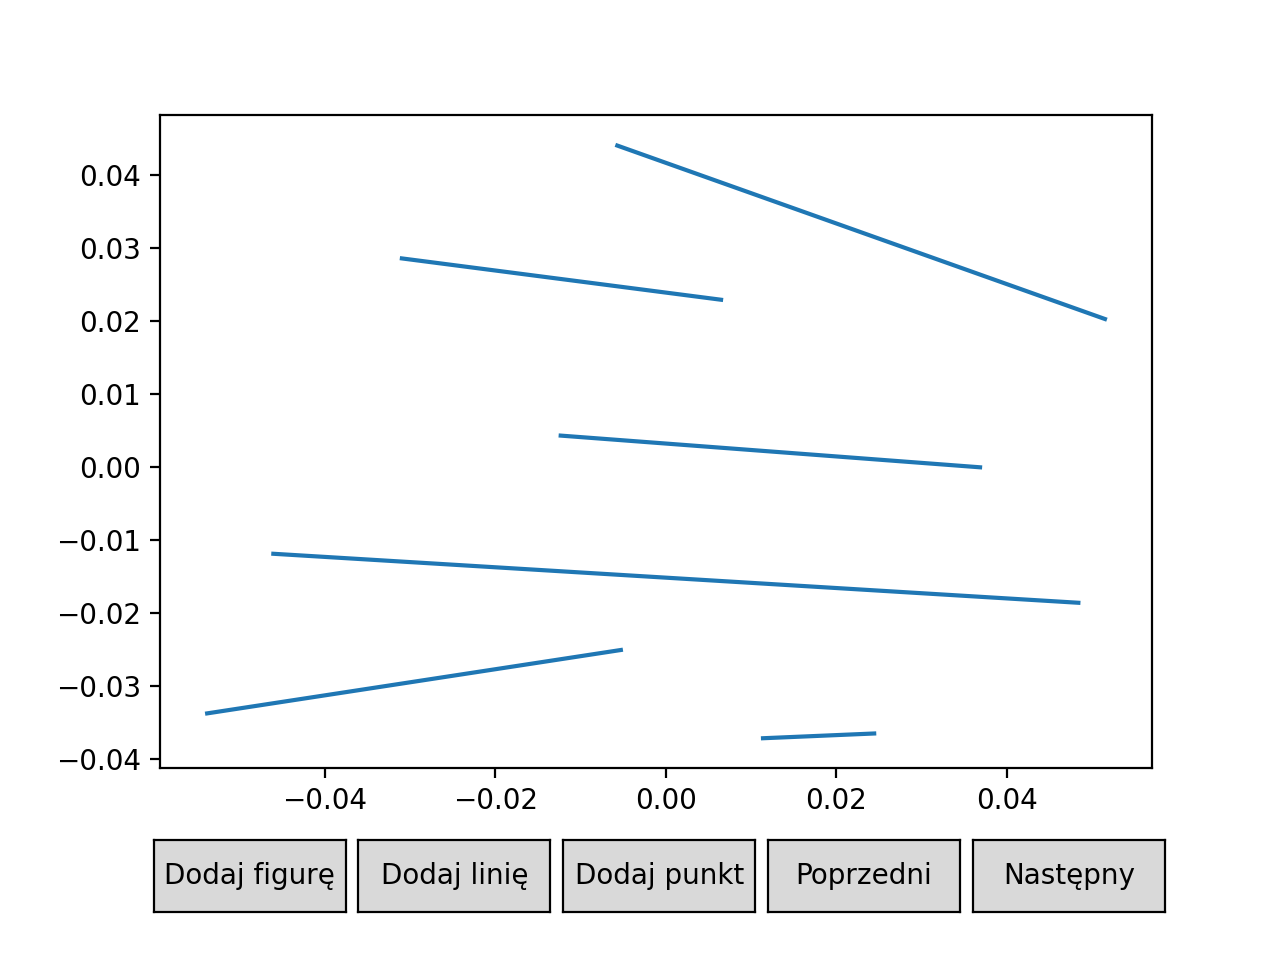

In [69]:
input_plot = Plot(scenes=[Scene()])
input_plot.draw()

In [70]:
# funkcja odpowiada za pobranie wczytanych odcinków z
# wykresu (Plot)
def get_input_lines(p):
    lines = []
    for collection in p.get_added_lines():
        for line in collection.lines:
            if line[0][0] < line[1][0]:
                lines.append(line)
            else:
                lines.append([line[1], line[0]])

    return lines


input_lines = get_input_lines(input_plot)
for line in input_lines:
    print(line)

[(-0.031167937247983876, 0.02859949448529414), (0.0067554498487903125, 0.022870327818627467)]
[(-0.012538904989919365, 0.004334788602941189), (0.037138514364919356, -4.63388480392013e-05)]
[(-0.05401067918346775, -0.033747319240196076), (-0.004998582409274199, -0.024985064338235295)]
[(-0.0462485824092742, -0.011841681985294117), (0.048670772429435474, -0.01858187806372548)]
[(0.011190933719758059, -0.037117417279411764), (0.024719159526209677, -0.03644339767156863)]
[(-0.005885679183467746, 0.0441019454656863), (0.0517756111391129, 0.020174249387254914)]


# Wizualizacja tworzenia mapy trapezowej

<IPython.core.display.Javascript object>


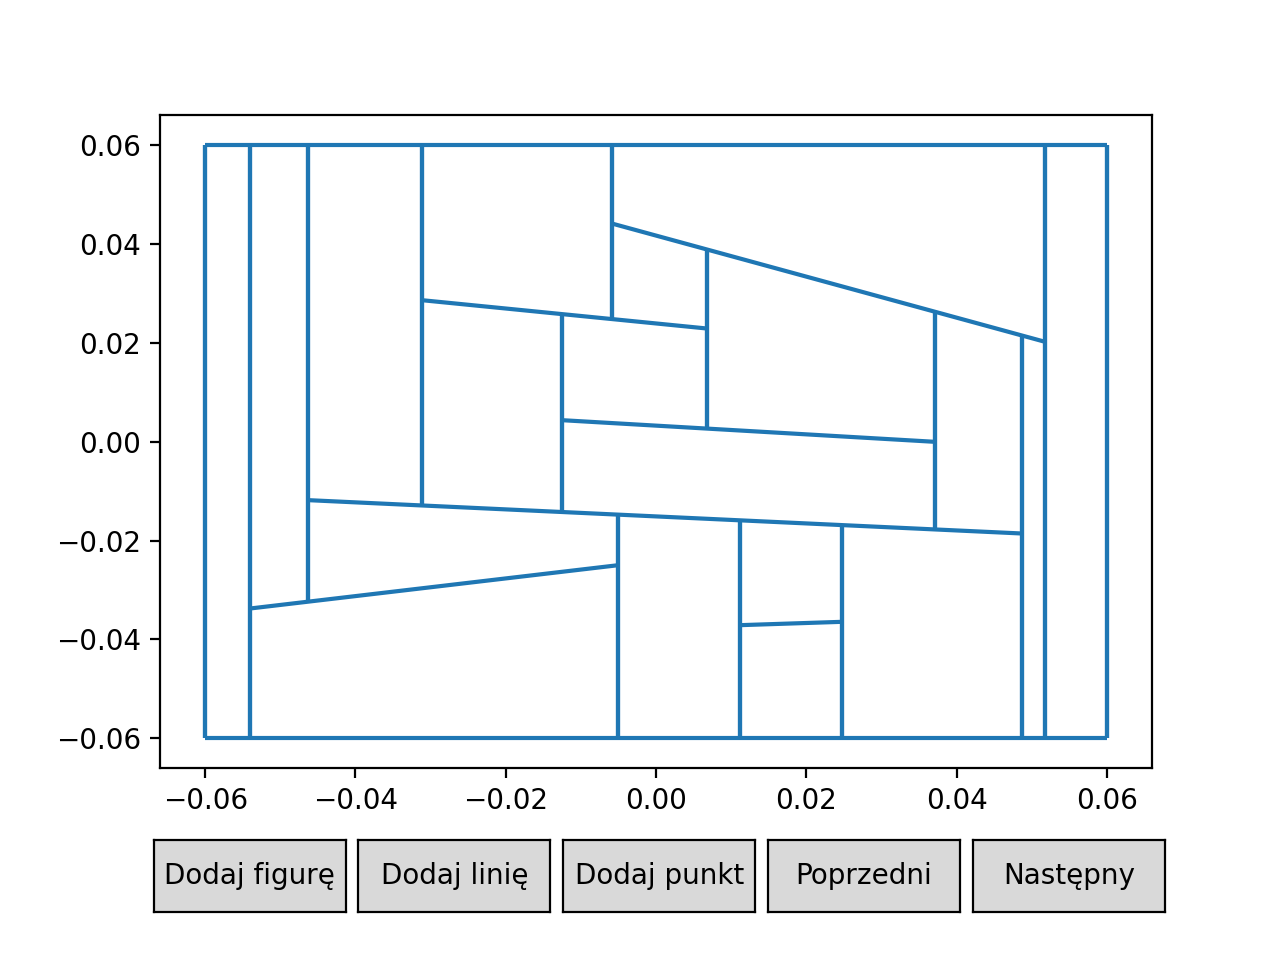

In [71]:
G = construct_map()
scenes = [Scene()]
for sc in CREATE_SCENESET:
    scenes += [sc.generate_deleted_scene(), sc.generate_added_scene(), sc.generate_normal_scene()]
plot_check = Plot(scenes)
plot_check.draw()

# Wczytywanie punktów

<IPython.core.display.Javascript object>


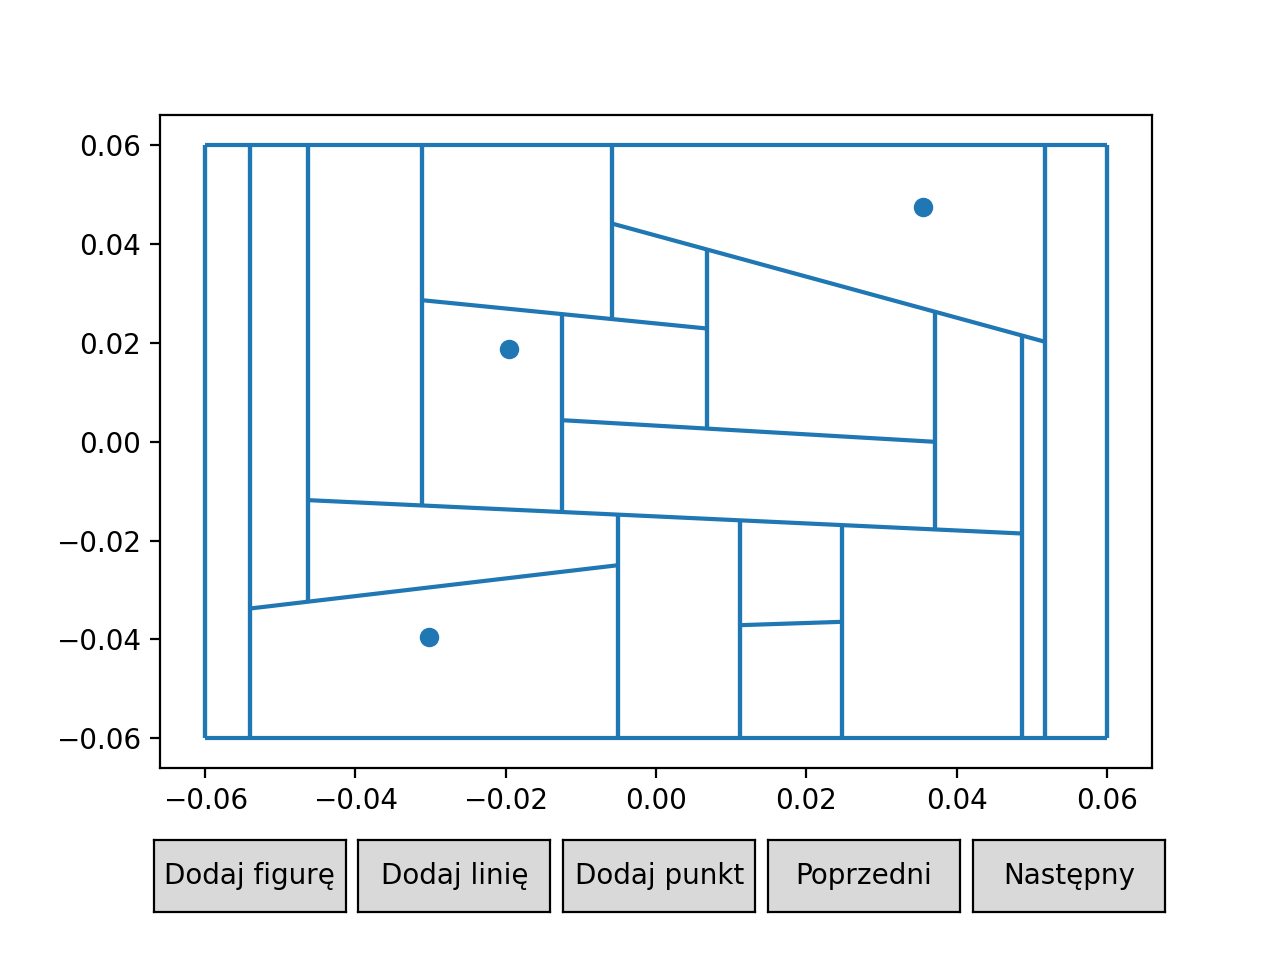

In [72]:
last_scene = CREATE_SCENESET[-1]

search_plot = Plot(scenes = [last_scene.generate_normal_scene()])
search_plot.draw()

# Wizualizacja odnajdywania położenia punktu

[(-0.030216040826612896, -0.03944784007352943), (-0.019570879536290317, 0.018787454044117635), (0.03551783014112904, 0.047500689338235286)]


<IPython.core.display.Javascript object>


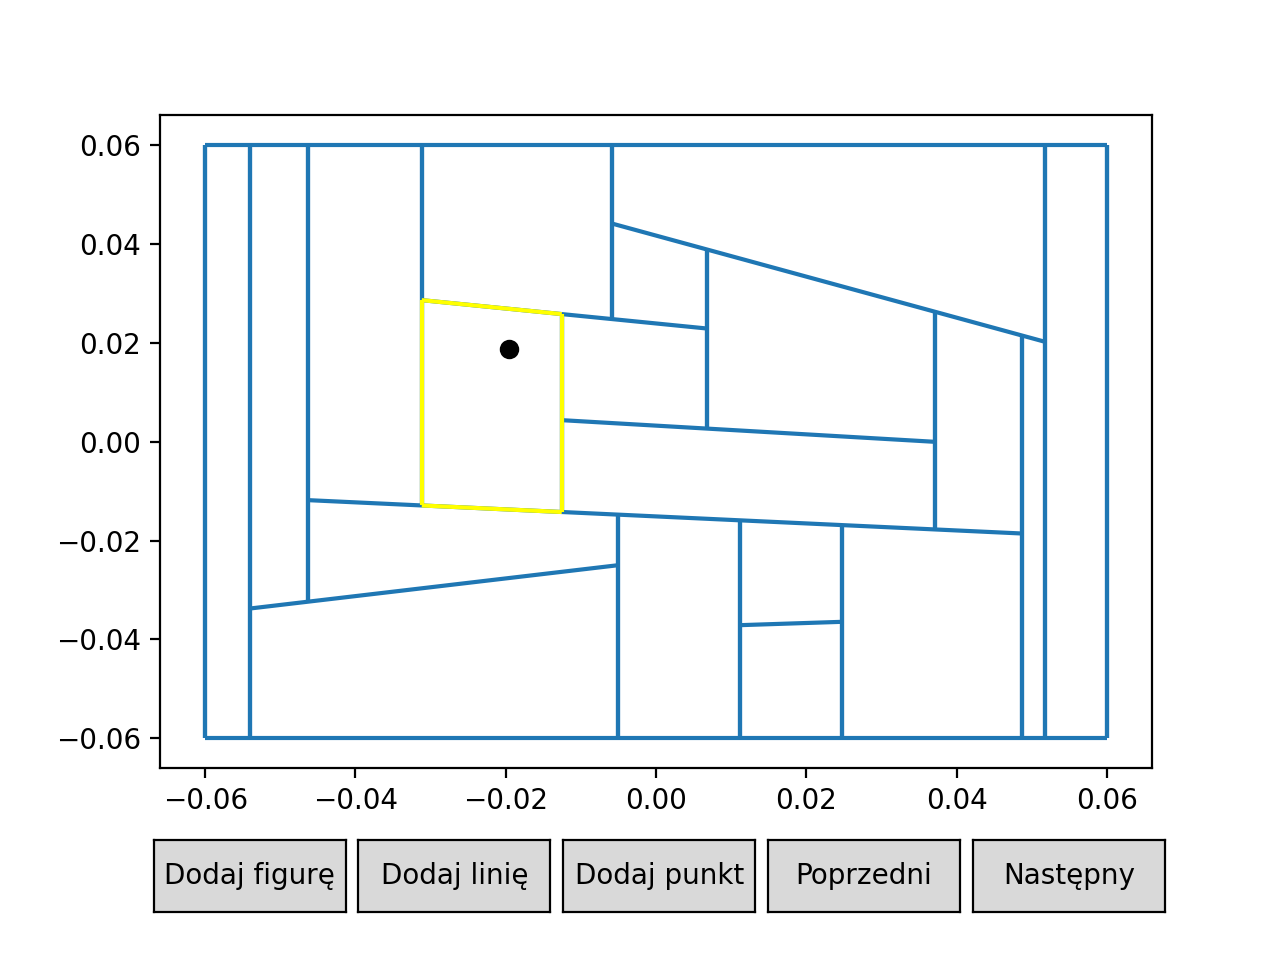

In [73]:
# pobieranie punktów z wykresu
added_points = []
for coll in search_plot.get_added_points():
    for point in coll.points:
        added_points.append(point)
print(added_points)


final_sceneset = []
# dla każdego punktu tworzę zbiór etapów wyszukiwania
for x, y in added_points:
    # czyszczenie zbioru kroków (scen)
    GRAPH_SCENESET = []
    searched_point = Point(x, y)
    find_in_graph(G.root, searched_point)
    for s in GRAPH_SCENESET:
        final_sceneset.append(s.create_scene())

search_visualisation_plot = Plot(scenes = final_sceneset)
search_visualisation_plot.draw()

# punkt, którego ściany poszukujemy = kolor czarny
# element, w którego wierzchołku w grafie aktualnie się znajdujemy - kolor żółty
# prawe dziecko (w prawo lub w górę) - zielony kolor
# lewe dziecko (w lewo lub w dół) - kolor czerwony